In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import json
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn import metrics


sys.path.append("/Users/efandel/Desktop/iPython Tools")
from rtbpythonutils import *
%matplotlib inline

In [11]:
feature_columns = ['app_site_id','fiksu_app_id','ad_type', 'ad_size', 'ad_network',
                   'device_country', 'fiksu_device', 'connection_speed']
negative_ratio = 1.0

positives = redshift_compute('''
select case when conversions > 0 then 1 else 0 end as label,
  %s
from research_prod.bid_summary_4wk
where fiksu_app_id != '0'
  and used_target = 'cost_per_download'
  and conversions > 0
order by random()
limit 100000
'''%(', '.join(feature_columns)))

negatives = redshift_compute('''
select case when conversions > 0 then 1 else 0 end as label,
  %s
from research_prod.bid_summary_4wk
where fiksu_app_id != '0'
  and used_target = 'cost_per_download'
  and conversions = 0
  and impressions > 0
order by random()
limit %s
'''%(', '.join(feature_columns), int(len(positives)*negative_ratio)))
data = pd.concat([positives, negatives])

In [12]:
data.head()

,label,app_site_id,fiksu_app_id,ad_type,ad_size,ad_network,device_country,fiksu_device,connection_speed
0,1,74837293ea4ba4593255307a1faeeb16,12710,LiveRailVideoAd,480x320,omax,USA,iphone,Cellular
1,1,eac02eb80a29d55fc5d40e60d3cdc3e7,12710,LiveRailVideoAd,480x320,omax,DNK,ipad,Cable/DSL
2,1,de2d3e6225ba4a48838f3cf9b8752a20,12711,LiveRailVideoAd,320x480,mopub,USA,generic android device,Cable/DSL
3,1,924cb2fc7847487793b92da332f6624e,12095,LiveRailVideoAd,480x320,mopub,USA,iphone,Cable/DSL
4,1,com.solitairegame.basic2,12711,StandardAd,1024x768,adx,USA,galaxy tab a,Cable/DSL


In [19]:
columns = ['app_site_id','fiksu_app_id','ad_type', 'ad_size', 'ad_network',
                   'device_country', 'fiksu_device', 'connection_speed']


x = pd.get_dummies(data[columns])
y = data['label']

In [20]:
scores = cross_val_score(DecisionTreeClassifier(), x, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

scores = cross_val_score(DecisionTreeClassifier(), x, y, scoring='accuracy', cv=5)
print('CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

CV AUC [ 0.66622705  0.66222049  0.65585264  0.66073171  0.65640413], Average AUC 0.66028720287
CV Accuracy [ 0.63282805  0.62746899  0.62639718  0.62869392  0.6227224 ], Average Accuracy 0.627622109937


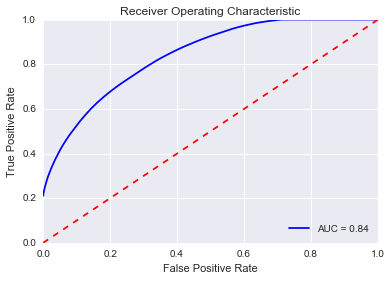

In [27]:
# calculate the fpr and tpr for all thresholds of the classification
model = DecisionTreeClassifier()
model.fit(x,y)
probs = model.predict_proba(x)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

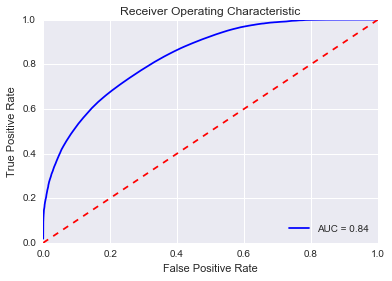

In [30]:
# calculate the fpr and tpr for all thresholds of the classification
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(x,y)
probs = model.predict_proba(x)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()